In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from Scrapping import BeautifulSoupScrape as BSC
from Project_Final_Scripts.date_utils import date_range
import time
import json

In [39]:
corona_ratio_data = '..\\corona_lb_ratios.csv'

pd.set_option('display.max_rows', 255)

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [3]:
df = pd.read_csv(corona_ratio_data, header=0)
df.head()

,date,year,month,day,new_cases,new_deaths,local,travelers,prev_cases,prev_deaths,total_cases,total_deaths,month_avg_ratio,cumulative_avg_ratio,diff_avg_ratio,simple_ratio
0,2/1/2020,2020,2,1,0,0,1,0,0,0,0,0,-1.0,-1.0,-0.111737,-0.055159
1,2/2/2020,2020,2,2,0,0,1,0,0,0,0,0,-1.0,-1.0,-0.111737,-0.055159
2,2/3/2020,2020,2,3,0,0,1,0,0,0,0,0,-1.0,-1.0,-0.111737,-0.055159
3,2/4/2020,2020,2,4,0,0,1,0,0,0,0,0,-1.0,-1.0,-0.111737,-0.055159
4,2/5/2020,2020,2,5,0,0,1,0,0,0,0,0,-1.0,-1.0,-0.111737,-0.055159


In [30]:
x =  [i for i in range(len(df))] # df.month.map(str) + '_' + df.day.map(str)
y = df.diff_avg_ratio

zero = [0 for _ in range(len(x))]

max_value = df.diff_avg_ratio.max()
maximum = [max_value for _ in range(len(x))]

min_value = df.diff_avg_ratio.min()
minimum = [min_value for _ in range(len(x))]

std_value = df.diff_avg_ratio.std()
pos_std = [std_value for _ in range(len(x))]
neg_std = [-std_value for _ in range(len(x))]

print('max:', max_value)
print('min:', min_value)
print('std:', std_value)

max: 1.0000000000000002
min: -1.0
std: 0.25409741210027786


In [31]:
hotspots_data = []
hotspots = []

def get_source(row):
    if row.local:
        source = 'locals'
        if row.travelers:
            source += '_travelers'
    else:
        source = 'travelers'
    return source

for index, row in df.iterrows():
    # negative hotspots
    if row.diff_avg_ratio < -std_value:
        hotspots_data.append({
            'date': row.date,
            'prev_cases': row.prev_cases,
            'new_cases': row.new_cases,
            'cases_diff': abs(row.new_cases - row.prev_cases),
            'ratio': row.diff_avg_ratio,
            'source': get_source(row)
        })
        hotspots.append(row.diff_avg_ratio)
        
    else:
        hotspots.append(None)
        
    
print(len(hotspots_data), 'negative hotspots')
print(len(hotspots), 'spots')

57 negative hotspots
243 spots


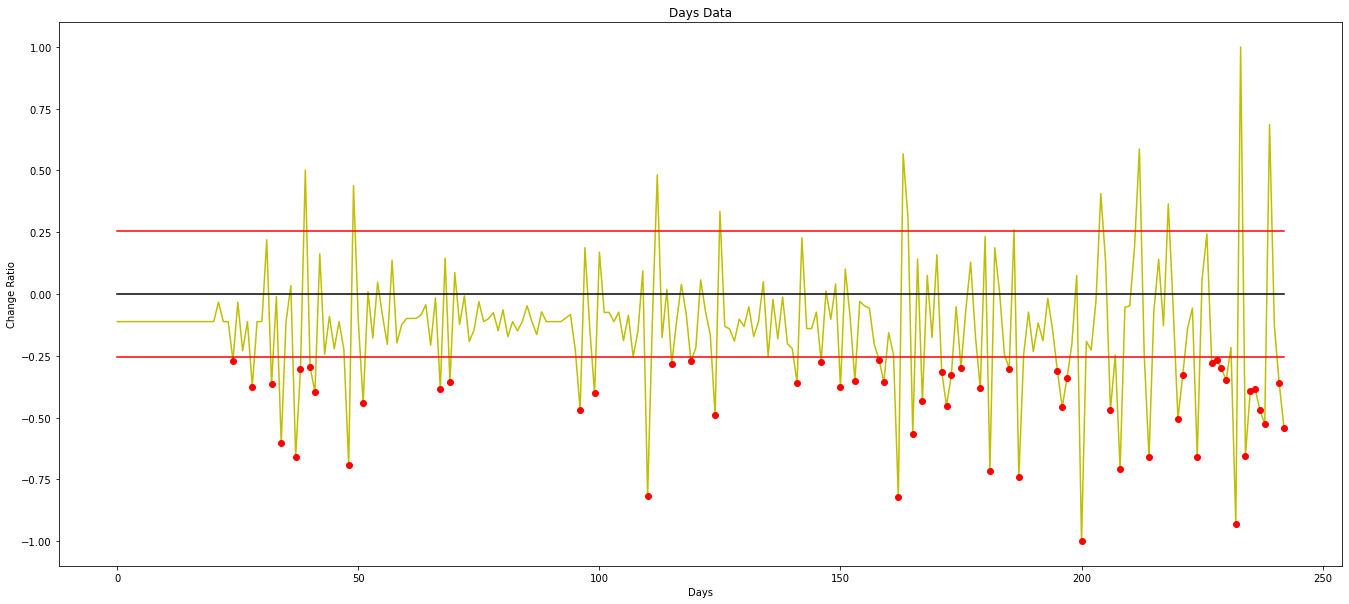

In [42]:
f, g = plt.subplots(figsize=(23, 10))
g.set_title('Days Data')
g.set(xlabel='Days', ylabel='Change Ratio')
g.plot(
    x, y, 'y', 
    x, zero, 'black',
#     x, maximum, 'r', 
#     x, minimum, 'r', 
    x, pos_std, 'r',
    x, neg_std, 'r',
    x, hotspots, 'ro'
)

In [7]:
for hotspot in hotspots_data:
    print(hotspot)
    print('---------------------------------------------------------------------------------------------------------------------------------------------')

{'date': '2/25/2020', 'prev_cases': 0, 'new_cases': 1, 'cases_diff': 1, 'ratio': -0.2693279105758257, 'source': 'locals'}
---------------------------------------------------------------------------------------------------------------------------------------------
{'date': '2/29/2020', 'prev_cases': 1, 'new_cases': 3, 'cases_diff': 2, 'ratio': -0.3743887116133297, 'source': 'locals'}
---------------------------------------------------------------------------------------------------------------------------------------------
{'date': '3/4/2020', 'prev_cases': 0, 'new_cases': 2, 'cases_diff': 2, 'ratio': -0.3638826315095793, 'source': 'locals'}
---------------------------------------------------------------------------------------------------------------------------------------------
{'date': '3/6/2020', 'prev_cases': 1, 'new_cases': 6, 'cases_diff': 5, 'ratio': -0.6042092138828695, 'source': 'locals'}
----------------------------------------------------------------------------------------

In [8]:
def get_trends(dates):
    final_trends = []
    
    for date in dates:
        # get trends
        trends = BSC.get_elements(
            "div.col-lg-8 > div > ul > li > a",
            source=f'https://trendogate.com/placebydate/23424873/{date}',
            attributes=True
        )
        # get trends data
        for trend in trends:
            final_trends.append({
                'topic': trend['text'].strip(),
                'link': 'https://trendogate.com/' + trend['href'],
                'tweets': []
            })

        # sleep
        time.sleep(0.5)

    return final_trends

#----------------------------------------------------------------------------------------------------

def get_hotspot_topics(date):
    global hotspots_topics_trends

    dates = date_range(date, '%m/%d/%Y', range_before=3, range_after=0)
    trends = get_trends(dates)

    print('[Date]:', date)
    print('[Trends]:', trends)
    print('------------------------------------------')

    return trends

#----------------------------------------------------------------------------------------------------

def get_hotspots_topics(hotspots):
    hotspots_trends = {}

    for hotspot in hotspots:
        trends = []
        if hotspot['source'] == 'locals':
            trends = get_hotspot_topics(hotspot['date'])
        hotspots_trends[hotspot['date']] = {
                **hotspot,
                'trends': trends
            }    

    with open('hotspots.json', 'w', encoding='utf-8') as f:
        f.write(json.dumps(hotspots_trends, indent=2, ensure_ascii=False))
    
    print('Done!!')

In [9]:
# get_hotspots_topics(hotspots_data)